# h3ronpy documentation

This notebook depends on the libraries from the `requirements.documentation.txt` file being installed.

In [1]:
# imports

from matplotlib import pyplot
import rasterio
from rasterio.plot import show
import numpy as np
import h3.api.numpy_int as h3
from scipy import ndimage

# increase the plot size
pyplot.rcParams['figure.dpi'] = 300

## Converting raster data to H3

### Prepare a dataset using rasterio

Load an dataset

(<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>)
(284, 327)


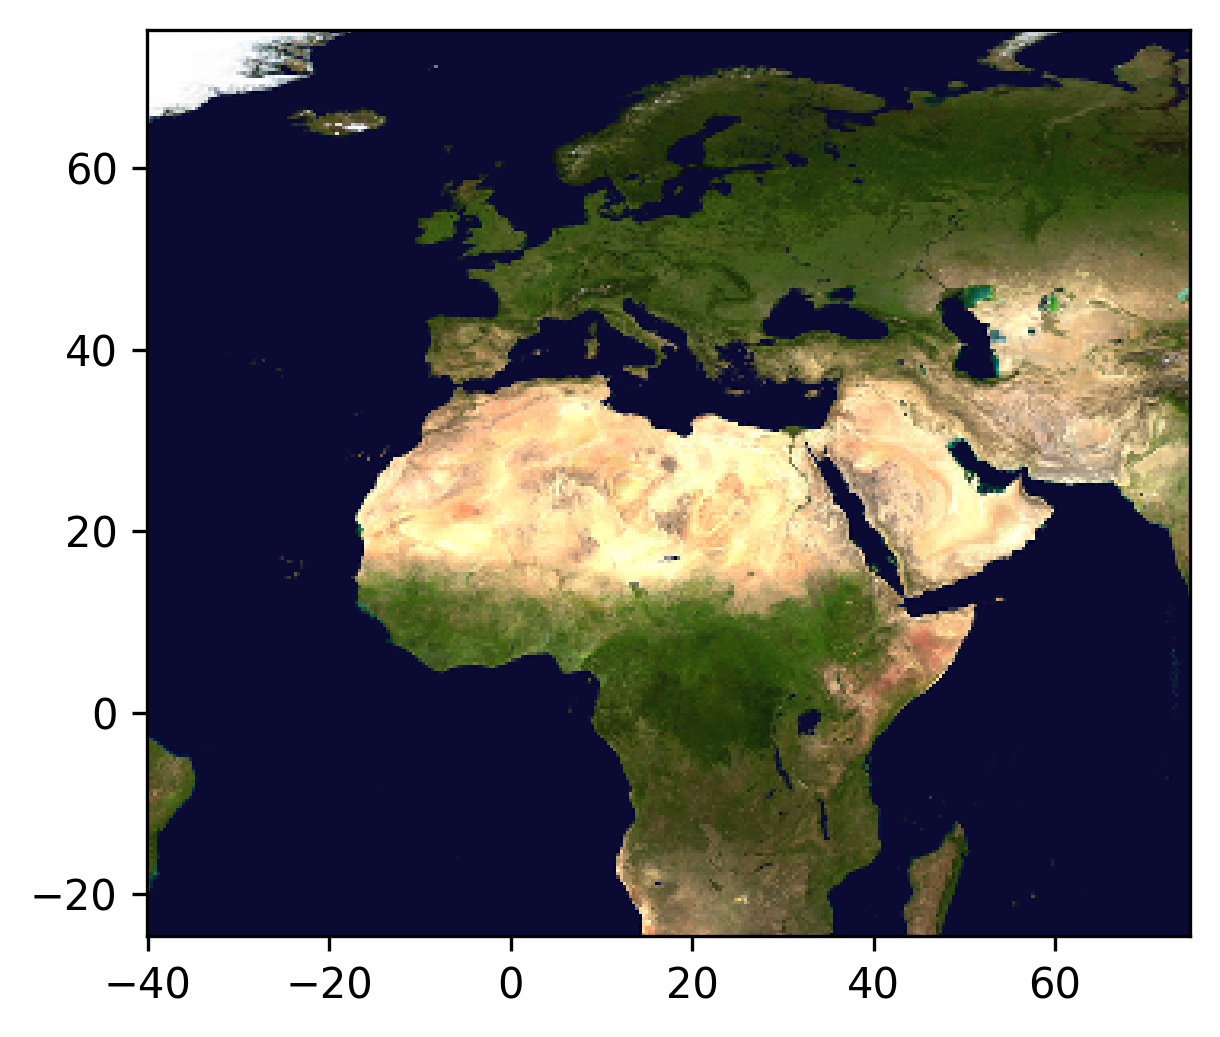

<AxesSubplot:>

In [2]:
src = rasterio.open("../data/europe-and-north-africa.tif")
print(src.colorinterp)

green = src.read(2)
blue = src.read(3)
print(green.shape)

show(src)

Do image processing, like the messy extraction and smoothing of the greenish pixels done here:

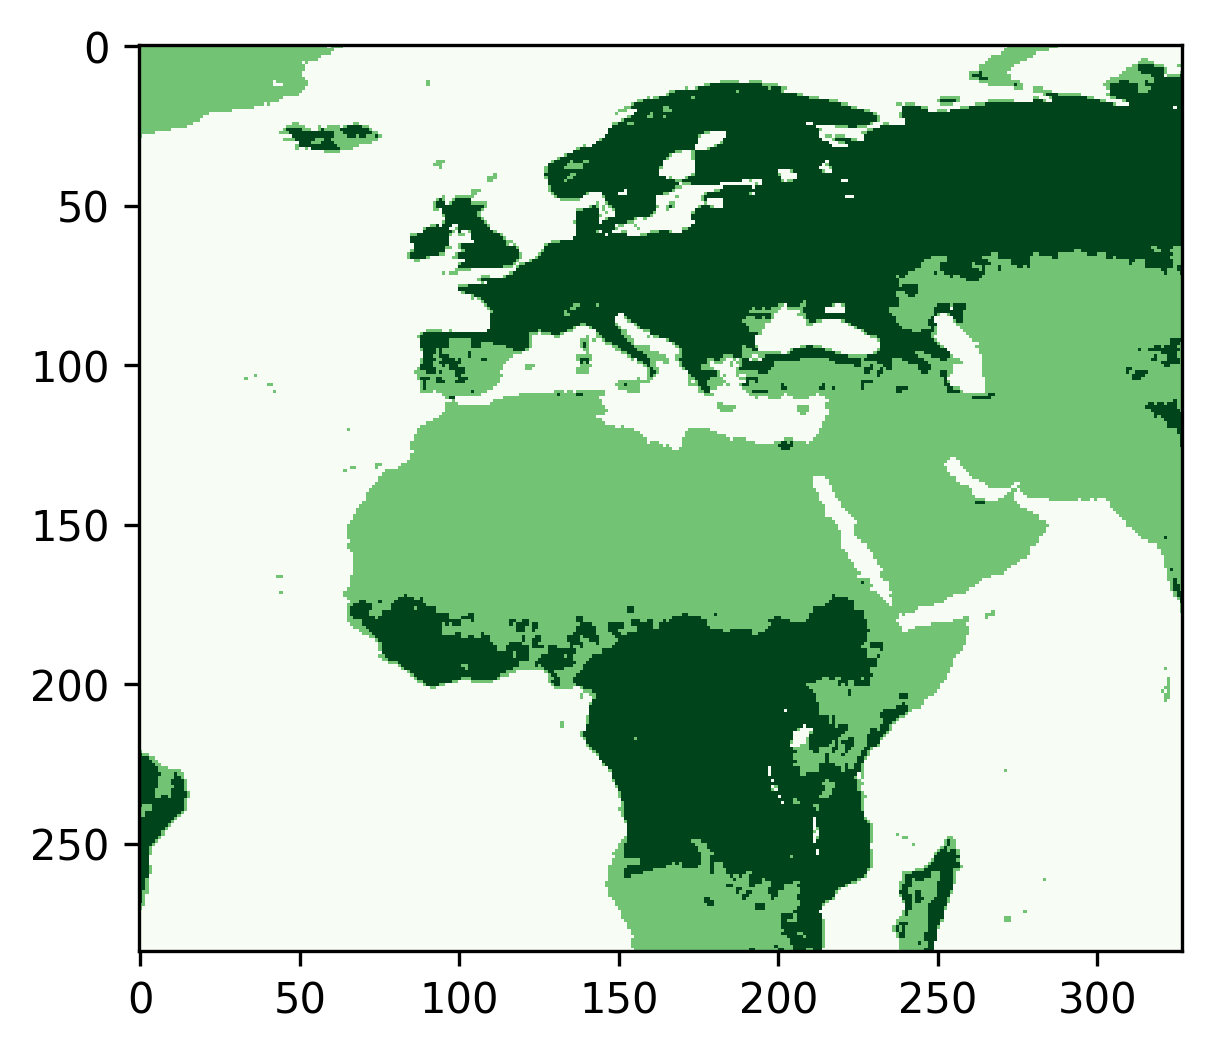

In [3]:
vegetation_mask = (green < 250) & (blue < 50)
ocean_mask = (green >= 6) & (green <= 14) & (blue >= 47) & (blue <= 54)
vegetation_nodata_value = 0

vegetation = np.full(green.shape, 10, dtype="int8")
vegetation[ocean_mask] = vegetation_nodata_value
vegetation[vegetation_mask] = 20
#pyplot.imshow(vegetation, cmap='Greens')

# smooth a bit to remove single pixels
vegetation = ndimage.gaussian_filter(vegetation, sigma=.7)
vegetation[vegetation <= 5] = vegetation_nodata_value
vegetation[(vegetation > 0) & (vegetation < 15)] = 1
vegetation[vegetation >= 15] = 2
vegetation[ocean_mask] = vegetation_nodata_value

vegetation_plot_args = dict(cmap='Greens', vmin=0, vmax=2)

pyplot.imshow(vegetation, **vegetation_plot_args)

In [4]:
vegetation

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

### Convert the numpy array to H3

Find the h3 resolution to use. See also the docstrings of the used functions and of the `h3ronpy.array` module.

In [5]:
from h3ronpy.array import nearest_h3_resolution

h3_res = nearest_h3_resolution(vegetation.shape, src.transform, search_mode="smaller_than_pixel")
print(f"Using H3 resolution {h3_res}")

Using H3 resolution 5


### ... into the internal wrapper objects:

In [6]:
from h3ronpy.array import array_to_h3


print("conversion start")
vegetation_h3 = array_to_h3(vegetation, src.transform, vegetation_nodata_value, h3_res)
print("conversion done")

for value, compacted_vec in vegetation_h3.items():
    print(f"found {compacted_vec.len()} compacted h3 indexes for value {value}")

vegetation_h3 = None # free some memory

conversion start
conversion done
found 15260 compacted h3 indexes for value 1
found 12077 compacted h3 indexes for value 2


### ... or directly into a pandas (geo-)dataframe:

conversion start
conversion done
plotting ... this may take a bit


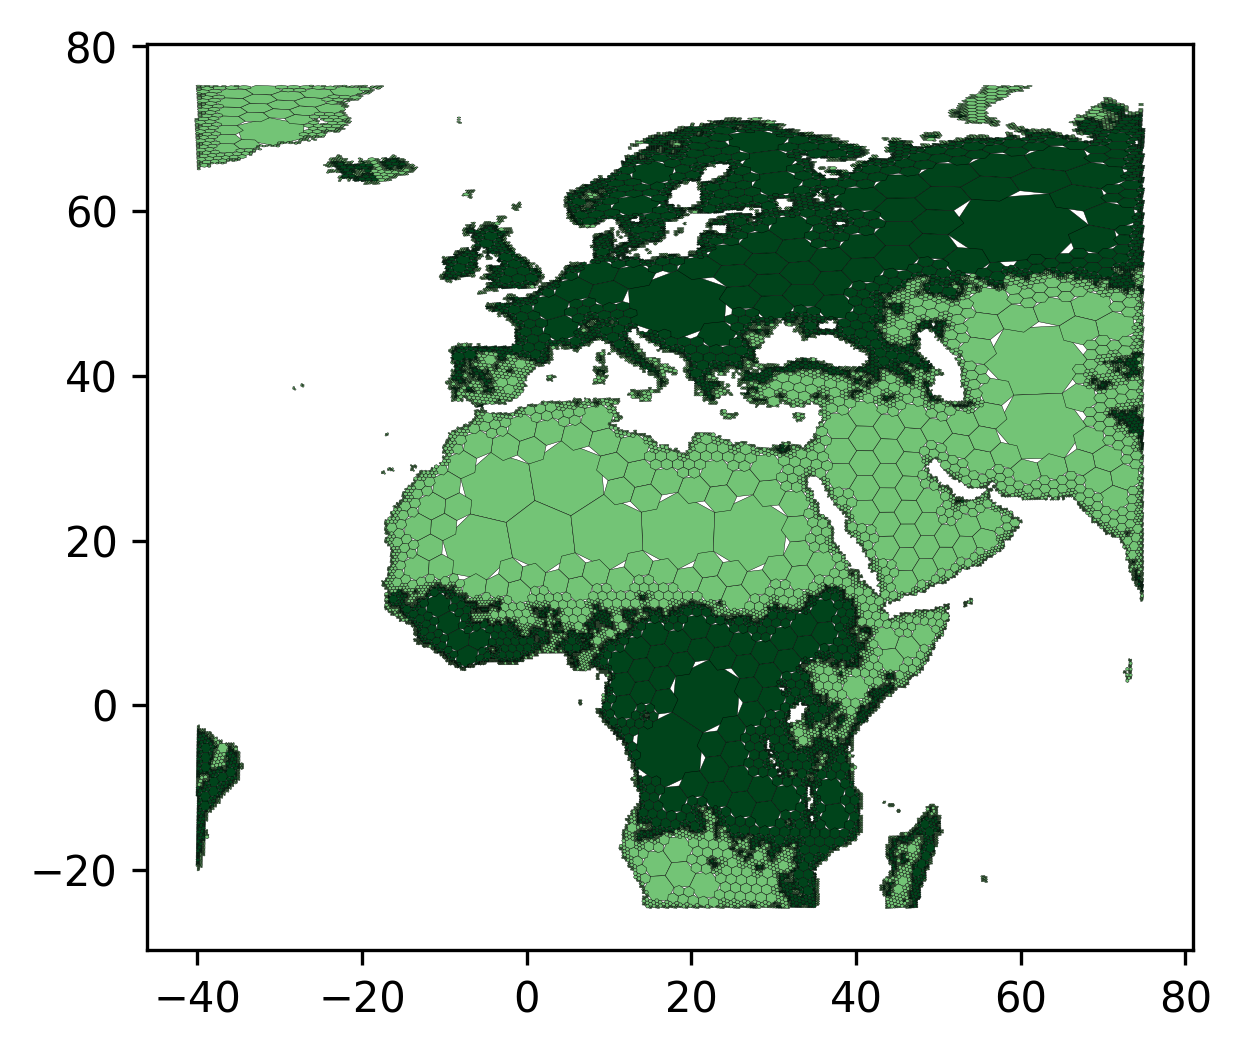

In [7]:
from h3ronpy.array import array_to_dataframe

print("conversion start")
vegetation_h3_df = array_to_dataframe(vegetation, src.transform, vegetation_nodata_value, h3_res, compacted=True, geo=True)
print("conversion done")

print("plotting ... this may take a bit")
vegetation_h3_df.plot(column="value", linewidth=0.1, edgecolor="black", **vegetation_plot_args)
pyplot.show()

## Using GDAL instead of rasterio

To not repeat any steps from above, we just save the processed data using `rasterio` and load it again using `gdal`.

In [8]:
# ... TBW ...